# Read Incidence Angle File

In [1]:
# import libraries
import re
import numpy as np
import zipfile
import getpass
from osgeo import gdal 
import os  # for chdir, getcwd, path.basename, path.exists
import pandas as pd # for DatetimeIndex
import codecs # for text parsing code
import netrc
import rasterio as rio
import rasterio.plot
import glob
import matplotlib.pyplot as plt

In [2]:
# folder is path to a folder with an .ann (or .txt) and .inc files

def uavsar_inc_to_tiff(folder):
    """
    Builds a header file for the input UAVSAR .inc file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .inc and .ann files
    """
    os.chdir(folder)
    
    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".inc":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "inc.set_rows" in line:
                    Lines = line[64:70]
                    print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "inc.set_cols" in line:
                    Samples = line[64:70]
                    print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "inc.row_addr" in line:
                    Latitude = line[64:85]
                    print(f"Top left lat: {Latitude}")
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "inc.col_addr" in line:
                    Longitude = line[64:85]
                    print(f"Top left Lon: {Longitude}")
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .inc files
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    

                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    data_to_process = glob.glob(os.path.join(folder, '*.inc')) # list all .inc files
    for data_path in data_to_process: # loop to open and translate .inc to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    

    print(".tiffs have been created")
    return

In [3]:
data_folder = '/home/jovyan/uavsar/grmesa_27416_21021_005_210322_L090_CX_01' # define folder where the .inc and .ann files are

In [4]:
uavsar_inc_to_tiff(data_folder) 

Number of Lines: 4163  
Number of Samples: 8949  
Top left lat: 39.17963412          
Top left Lon: -108.37516932000001  
.tiffs have been created


In [5]:
tiff_file = os.path.join(data_folder, os.path.basename(data_folder) + '.inc.tiff')
inc_rast = rio.open(tiff_file)
meta_data = inc_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8949, 'height': 4163, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.37516932000001,
       0.0, -5.556e-05, 39.17963412), 'tiled': False, 'interleave': 'band'}


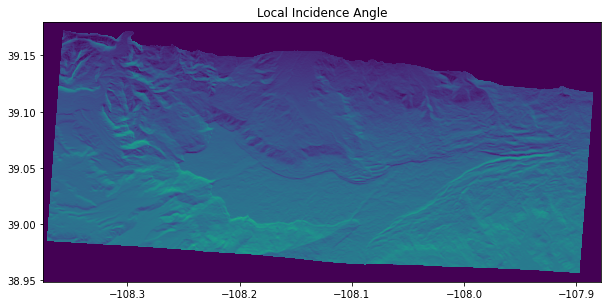

In [6]:
f,ax=plt.subplots(figsize=(10,7))
ax.set_title('Local Incidence Angle')
rio.plot.show(inc_rast,vmin=0,vmax=3);